# Unsupervised Anomaly Detection Benchmark

This notebook implements and benchmarks three complementary unsupervised algorithms on the pre-processed cybersecurity dataset (Packet-based).

**Algorithms:**
1.  **Isolation Forest** (Tree-based)
2.  **PCA Reconstruction Error** (Linear/Reconstruction-based)
3.  **Local Outlier Factor (LOF)** (Density-based)

**Metrics:**
*   Confusion Matrix
*   Precision, Recall
*   AUPRC (Average Precision)
*   Balanced Accuracy
*   Matthews Correlation Coefficient (MCC)

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, precision_recall_curve, auc)

pkl_path = '../data/packet_data_balanced.pkl'

print(f"Loading data from {pkl_path}...")
try:
    df = pd.read_pickle(pkl_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"File {pkl_path} not found. Please ensure the EDA notebook has been run.")

display(df.head())
print(df['Main_Label'].value_counts())

Loading data from ../data/packet_data_balanced.pkl...
Data loaded successfully. Shape: (500000, 138)


,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,Main_Label,Sub_Label,Source_File
0,-1,Netatmo Weather Station,ff:ff:ff:ff:ff:ff,Unknown,Unknown,0,0,992.865187,0.000082,2,...,0.0,0.00,0.000000,0.0,0.0,0.0,1.0,Web-Based,BrowserHijacking,BrowserHijacking.csv
1,177736,dc:a6:32:c9:e5:ef,SmartThings Hub,192.168.137.158,192.168.137.35,48863,10800,51.918555,0.000151,2,...,536.0,536.00,0.000000,536.0,536.0,0.0,70.0,Mirai,Mirai-greip_flood,Mirai-greip_flood21.csv
2,21193,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,54.77.42.87,55169,443,1693.062619,0.001555,1,...,1450.5,807.45,544961.418421,1460.0,12.0,1448.0,51.0,Recon,Recon-OSScan,Recon-OSScan.csv
3,-1,GoSund Power strip (2),ff:ff:ff:ff:ff:ff,Unknown,Unknown,0,0,6270.430885,0.002378,1,...,188.0,122.20,8463.957895,188.0,0.0,188.0,2.0,Recon,Recon-PortScan,Recon-PortScan.csv
4,1628,3c:18:a0:41:c3:a0,Smart Board,142.251.41.86,192.168.137.13,443,38063,2101.311867,0.000002,2,...,1250.0,1217.45,21190.050000,1250.0,1250.0,0.0,17.0,Spoofing,MITM-ArpSpoofing,MITM-ArpSpoofing1.csv


Main_Label
Web-Based        62500
Mirai            62500
Recon            62500
Spoofing         62500
DDoS             62500
BenignTraffic    62500
BruteForce       62500
DoS              62500
Name: count, dtype: int64


In [2]:
# 1. Data Preprocessing
print("Preprocessing Data...")

# 1.1 Define Ground Truth
# Anomalies = 1, Normal = 0
# Assuming 'BenignTraffic' or 'Benign' is normal.
normal_labels = ['BenignTraffic', 'Benign']
y_true = df['Main_Label'].apply(lambda x: 0 if x in normal_labels else 1).values

print(f"Class Balance: Normal={np.sum(y_true==0)}, Anomaly={np.sum(y_true==1)}")
print(f"Anomaly Rate: {np.mean(y_true):.2%}")

# 1.2 Drop Labels and Identifiers
# Drop non-numerical columns or identifiers
cols_to_drop = ['Main_Label', 'Sub_Label', 'Source_File', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'Timestamp', 'Flow ID', 'Label']
# Drop whatever exists
existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
X_raw = df.drop(columns=existing_cols_to_drop)

# Select only numeric features
X_numeric = X_raw.select_dtypes(include=[np.number])
print(f"Numeric Feature Shape: {X_numeric.shape}")

# 1.4 Handle Missing Values
X_clean = X_numeric.fillna(X_numeric.mean()).fillna(0) # Simple imputation

# 1.5 Scaling
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
print("Scaling complete.")

Preprocessing Data...
Class Balance: Normal=62500, Anomaly=437500
Anomaly Rate: 87.50%
Numeric Feature Shape: (500000, 119)
Scaling features...
Scaling complete.


In [5]:
# 2. Model 1: Isolation Forest
print("Training Isolation Forest...")

iso_forest = IsolationForest(
    n_estimators=100, 
    max_samples=0.5,        # Use 50% of the dataset for each tree
    contamination='auto', 
    random_state=42, 
    n_jobs=-1
)

iso_forest.fit(X_scaled)

# Save Model
with open('../models/iso_forest_model.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)
print("Isolation Forest model saved to '../models/iso_forest_model.pkl'")

Training Isolation Forest...
Isolation Forest model saved to '../models/iso_forest_model.pkl'


### Model 1: Isolation Forest

**How it works:**
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. Anomalies, being "few and different," are more susceptible to isolation and thus have shorter path lengths.

**Why it is appropriate:**
*   **Efficiency:** It is computationally efficient and works well with high-dimensional datasets like network traffic data.
*   **No Distance Calculation:** Unlike distance-based methods (like k-NN), it doesn't incur the high cost of calculating pairwise distances.
*   **Rare Events:** It is specifically designed to detect rare events (anomalies) rather than profiling normal data points.

In [6]:
# 3. Model 2: PCA Reconstruction Error
print("Training PCA...")

# Keep 95% of variance or fixed components
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_scaled)

# Save Model
with open('../models/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)
print("PCA model saved to '../models/pca_model.pkl'")

Training PCA...
PCA model saved to '../models/pca_model.pkl'


### Model 2: PCA Reconstruction Error

**How it works:**
Principal Component Analysis (PCA) is a dimensionality reduction technique. For anomaly detection, we project the data onto a lower-dimensional subspace (capturing the normal variance) and then project it back to the original space. The "Reconstruction Error" serves as the anomaly score. Normal data points are well-reconstructed (low error), while anomalies (which don't conform to the correlation structure of normal data) are poorly constructed (high error).

**Why it is appropriate:**
*   **Correlation Breaking:** Cyber attacks often disrupt the normal correlation structure between features (e.g., specific flags correlated with packet sizes). PCA is excellent at detecting these disruptions.
*   **Linear Dependencies:** It assumes that normal network traffic lies on a lower-dimensional linear subspace, which is often a valid assumption for baseline traffic behavior.

In [7]:
# 4. Model 3: Local Outlier Factor
print("Training LOF...")

# Subsampling for LOF (computationally expensive)
lof_sample_size = 100000 
if X_scaled.shape[0] > lof_sample_size:
    print(f"Subsampling LOF to {lof_sample_size} samples due to complexity...")
    indices = np.random.choice(X_scaled.shape[0], lof_sample_size, replace=False)
    X_lof = X_scaled[indices]
    y_true_lof = y_true[indices]
else:
    print("Using full dataset for LOF.")
    X_lof = X_scaled
    y_true_lof = y_true

# n_neighbors=20 is default. 
# novelty=False (default) uses the dataset itself for scoring (Transductive) which is what we need for batch analysis.
lof = LocalOutlierFactor(n_neighbors=20, novelty=False, n_jobs=-1)
lof.fit(X_lof) 

# Save Model
with open('../models/lof_model.pkl', 'wb') as f:
    pickle.dump(lof, f)
print("LOF model saved to '../models/lof_model.pkl'")

Training LOF...
Subsampling LOF to 100000 samples due to complexity...
LOF model saved to '../models/lof_model.pkl'


### Model 3: Local Outlier Factor (LOF)

**How it works:**
The Local Outlier Factor (LOF) algorithm is a density-based method. It computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

**Why it is appropriate:**
*   **Local Anomalies:** Unlike Isolation Forest (which is global), LOF can detect "local" anomalies—attacks that might look normal in the global distribution but are outliers relative to their immediate neighborhood.
*   **Density Variation:** It handles datasets where different clusters have different densities well (e.g., high-volume HTTP traffic vs. low-volume DNS traffic).
*   **Complementary:** It provides a different perspective (density vs. isolation vs. linear reconstruction), helping to cover "blind spots" of other algorithms.

In [8]:
# 5. Helper Function: Evaluation Metrics
def evaluate_model(y_true, y_scores, model_name="Model", threshold_percentile=None):
    """
    Evaluates model performance using raw anomaly scores.
    higher score = more anomalous
    """
    print(f"\n--- Evaluating {model_name} ---")
    
    # Determine threshold
    if threshold_percentile is not None:
        thresh = np.percentile(y_scores, threshold_percentile)
    else:
        # Default: Use the ground truth anomaly rate as the expected contamination
        # If model is perfect, top N scores (where N = num anomalies) should be anomalies
        current_anomaly_rate = np.mean(y_true)
        # Score at (1 - anomaly_rate) percentile
        thresh = np.percentile(y_scores, (1 - current_anomaly_rate) * 100)
        
    print(f"Threshold used: {thresh:.4f}")
    
    # Binary predictions
    y_pred = (y_scores > thresh).astype(int)
    
    # Metrics
    cm = confusion_matrix(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_scores)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print("Confusion Matrix:")
    print(cm)
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUPRC:     {auprc:.4f}")
    print(f"Bal Acc:   {bal_acc:.4f}")
    print(f"MCC:       {mcc:.4f}")
    
    # Plot CM
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly'], 
                yticklabels=['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        "Model": model_name,
        "Precision": prec,
        "Recall": rec,
        "AUPRC": auprc,
        "Balanced Accuracy": bal_acc,
        "MCC": mcc
    }

print("Evaluation function defined.")

Evaluation function defined.



--- Starting Final Benchmark ---

1. Benchmarking Isolation Forest...

--- Evaluating Isolation Forest ---
Threshold used: -0.1770
Confusion Matrix:
[[ 13015  49485]
 [ 49518 387982]]
Precision: 0.8869
Recall:    0.8868
AUPRC:     0.8918
Bal Acc:   0.5475
MCC:       0.0950


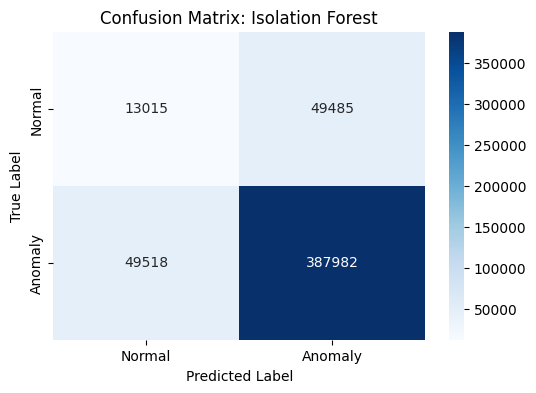


2. Benchmarking PCA...

--- Evaluating PCA ---
Threshold used: 0.0064
Confusion Matrix:
[[  7513  54987]
 [ 54987 382513]]
Precision: 0.8743
Recall:    0.8743
AUPRC:     0.8504
Bal Acc:   0.4973
MCC:       -0.0055


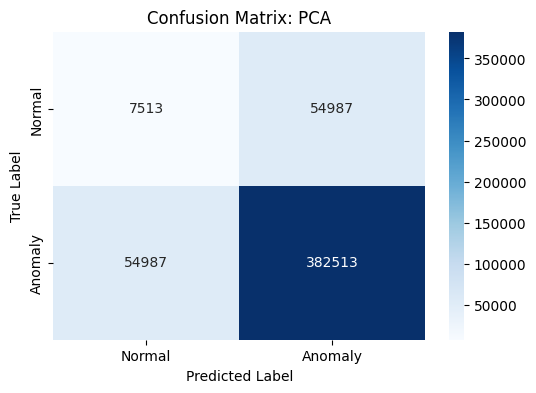


3. Benchmarking LOF...
LOF scores length (100000) != Full data length (500000)
Using subsampled labels `y_true_lof` from training step.

--- Evaluating LOF (Subsampled) ---
Threshold used: 0.9892
Confusion Matrix:
[[ 1437 11092]
 [11092 76379]]
Precision: 0.8732
Recall:    0.8732
AUPRC:     0.8744
Bal Acc:   0.4939
MCC:       -0.0121


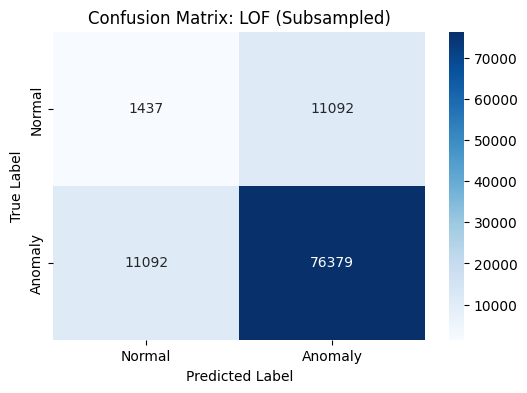

,Model,Precision,Recall,AUPRC,Balanced Accuracy,MCC
0,Isolation Forest,0.886883,0.886816,0.891809,0.547528,0.095034
1,PCA,0.874315,0.874315,0.850386,0.497262,-0.005477
2,LOF (Subsampled),0.873192,0.873192,0.874402,0.493943,-0.012114


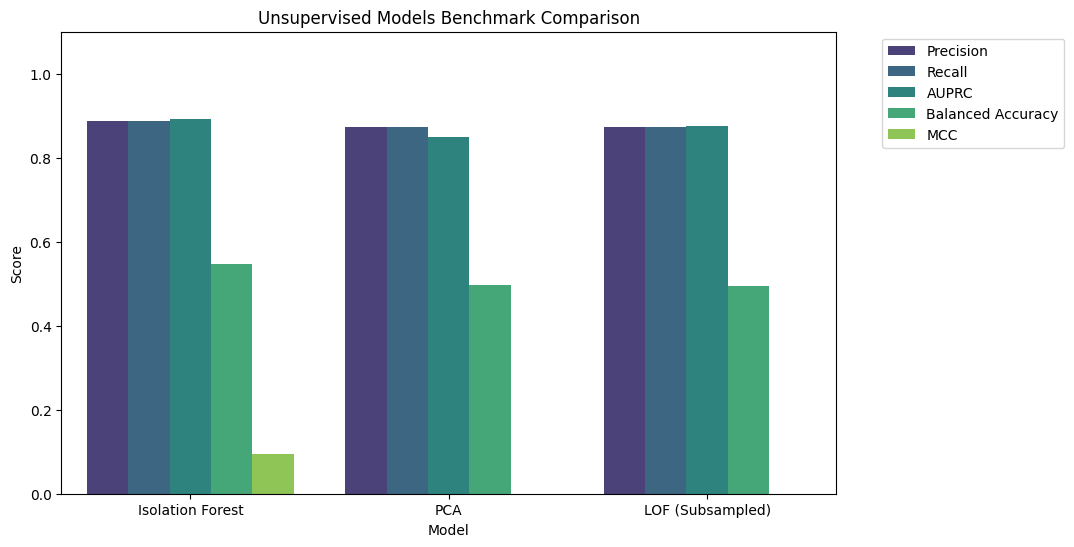

In [10]:
# 6. Final Benchmark using Saved Models
print("\n--- Starting Final Benchmark ---")

results = []

# --- 1. Isolation Forest ---
print("\n1. Benchmarking Isolation Forest...")
try:
    with open('../models/iso_forest_model.pkl', 'rb') as f:
        loaded_iso = pickle.load(f)
    
    # Predict on full dataset
    iso_scores = -loaded_iso.decision_function(X_scaled)
    # Evaluate
    res_iso = evaluate_model(y_true, iso_scores, model_name="Isolation Forest")
    results.append(res_iso)
except Exception as e:
    print(f"Error benchmarking Isolation Forest: {e}")

# --- 2. PCA ---
print("\n2. Benchmarking PCA...")
try:
    with open('../models/pca_model.pkl', 'rb') as f:
        loaded_pca = pickle.load(f)
    
    # Reconstruct full dataset
    X_pca_trans = loaded_pca.transform(X_scaled)
    X_recon = loaded_pca.inverse_transform(X_pca_trans)
    pca_scores = np.mean(np.square(X_scaled - X_recon), axis=1)
    
    # Evaluate
    res_pca = evaluate_model(y_true, pca_scores, model_name="PCA")
    results.append(res_pca)
except Exception as e:
    print(f"Error benchmarking PCA: {e}")

# --- 3. LOF ---
print("\n3. Benchmarking LOF...")
try:
    with open('../models/lof_model.pkl', 'rb') as f:
        loaded_lof = pickle.load(f)
    
    # LOF (novelty=False) only has scores for the data it was trained on.
    lof_scores = -loaded_lof.negative_outlier_factor_
    
    # We need to match these scores to the correct y_true labels.
    # Check if we used subsampling by comparing lengths
    if len(lof_scores) != len(y_true):
        print(f"LOF scores length ({len(lof_scores)}) != Full data length ({len(y_true)})")
        if 'y_true_lof' in locals():
            print("Using subsampled labels `y_true_lof` from training step.")
            res_lof = evaluate_model(y_true_lof, lof_scores, model_name="LOF (Subsampled)")
            results.append(res_lof)
        else:
            print("Error: `y_true_lof` variable not found. Cannot align subsampled scores labels.")
    else:
        # Full dataset was used
        res_lof = evaluate_model(y_true, lof_scores, model_name="LOF")
        results.append(res_lof)

except Exception as e:
    print(f"Error benchmarking LOF: {e}")

# --- Comparison & Visualization ---
if results:
    results_df = pd.DataFrame(results)
    display(results_df)

    # Plot
    plt.figure(figsize=(10, 6))
    melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
    # Filter metrics to plot
    metrics_to_plot = ['Precision', 'Recall', 'AUPRC', 'Balanced Accuracy', 'MCC']
    sns.barplot(data=melted[melted['Metric'].isin(metrics_to_plot)], 
                x='Model', y='Score', hue='Metric', palette='viridis')
    plt.title("Unsupervised Models Benchmark Comparison")
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("No results to display.")